<div style='background: linear-gradient(135deg, #1a3a5c 0%, #2e6da4 100%); padding: 40px 50px; border-radius: 12px; color: white; margin-bottom: 10px;'>

<h1 style='font-size: 2.2em; margin-bottom: 8px; font-weight: 700;'>
Thickener Water Recovery Sentinel (TWS)
</h1>
<h2 style='font-size: 1.2em; font-weight: 300; margin-bottom: 30px; opacity: 0.9;'>
Machine Learning para Detección Temprana de Crisis de Turbidez en Espesadores Cu/Mo
</h2>

<hr style='border-color: rgba(255,255,255,0.3); margin: 20px 0;'/>

<table style='color: white; font-size: 0.95em; border: none;'>
<tr><td style='padding: 4px 24px 4px 0; opacity: 0.7;'>Proceso objetivo</td><td><strong>Espesador convencional de concentrado Cu/Mo</strong></td></tr>
<tr><td style='padding: 4px 24px 4px 0; opacity: 0.7;'>Dataset</td><td><strong>Sintético operacionalmente calibrado · 90 días · 5 min · 25,920 obs.</strong></td></tr>
<tr><td style='padding: 4px 24px 4px 0; opacity: 0.7;'>Modelos</td><td><strong>Random Forest · LightGBM · Regla de proceso</strong></td></tr>
<tr><td style='padding: 4px 24px 4px 0; opacity: 0.7;'>Estado</td><td><strong>Proof-of-concept · Validación con datos reales requerida</strong></td></tr>
<tr><td style='padding: 4px 24px 4px 0; opacity: 0.7;'>Versión</td><td><strong>v1.0 — Febrero 2026</strong></td></tr>
</table>

</div>

---

## Abstract

Las crisis de turbidez en el overflow de espesadores convencionales representan uno de los modos de falla de mayor impacto en la recuperación de agua de proceso en plantas concentradoras de Cu/Mo. La detección actual basada en umbrales estáticos de turbidez medida provee aviso solo cuando la crisis ya se ha instaurado, dejando al operador con una ventana de reacción insuficiente.

Este trabajo presenta **TWS (Thickener Water Recovery Sentinel)**, un framework de ML para anticipación y diagnóstico de estas crisis sobre señales de proceso en tiempo real. Se desarrolló y evaluó sobre un dataset sintético de 90 días calibrado para reproducir el comportamiento dinámico de un espesador Cu/Mo operando bajo tres regímenes: operación normal, ingreso de arcilla fina (CLAY), y degradación de underflow (UF).

**Contribuciones principales:**

1. **Alerta temprana a 30 minutos** mediante Random Forest sobre 221 features temporales derivadas de 30 tags de proceso — PR-AUC = 0.795, Recall = 79.5% (vs. PR-AUC = 0.663 del baseline de umbral).
2. **Diagnóstico de causa raíz CLAY/UF** con exactitud del 93.1% mediante regla física de nivel de lecho, con LightGBM como respaldo ante fallas de sensor.
3. **Cuantificación de la brecha de datos** para alertas preventivas de 2h: el Componente B alcanza PR-AUC = 0.134 con datos de sensor online, y se demuestra cuantitativamente que la incorporación de análisis granulométrico de laboratorio es el factor limitante para mejorar substancialmente este horizonte.

Los resultados son consistentes con la física del proceso y sugieren que el framework es transferible a plantas con espesadores similares, sujeto a re-entrenamiento sobre datos reales de planta.

In [1]:
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

---

## 1. Contexto Técnico del Proceso

### Dinámica de turbidez en espesadores convencionales

En un espesador de rastrillos, el overflow clarificado debe mantenerse por debajo de un límite de turbidez operacional (típicamente 50–100 NTU según el circuito aguas abajo). El mecanismo de clarificación depende de la formación y mantenimiento de un **lecho de lodos** cohesivo que actúe como filtro profundo, asistido por la adición de floculante de alto peso molecular.

La turbidez del overflow resulta de la competencia entre dos procesos:
- **Sedimentación** de partículas floculadas hacia el lecho
- **Arrastre** de finos no floculados o re-suspendidos hacia la zona de overflow

Este balance es perturbado por dos modos de falla distintos que TWS busca identificar:

| Modo | Causa raíz | Mecanismo de turbidez | Señales precursoras |
|---|---|---|---|
| **CLAY** | Aumento de fracción de arcillas en alimentación (ej. kaolinita, illita) | Arcillas interfieren con floculación → finos no capturados → lecho alto y rígido | ↑ Clay index, ↑ pH feed, ↑ BedLevel, ↑ RakeTorque |
| **UF** | Degradación del sistema de purga de underflow (bomba, válvula, taponamiento) | Acumulación de sólidos → colapso del lecho → resuspensión masiva | ↓ Qu_m3h, ↑ Solids_u_pct, BedLevel moderado |

### Por qué la detección temprana es técnicamente difícil

El principal desafío es que ambos modos de falla exhiben señales precursoras **débiles y de baja relación señal/ruido** en el espacio de sensores estándar de planta:

- La turbidez medida (`Overflow_Turb_NTU`) es la señal más discriminante, pero por definición solo detecta el problema cuando ya está en curso.
- Las señales upstream (BedLevel, RakeTorque, pH) varían lentamente y tienen alta varianza natural, dificultando la detección de tendencias incipientes.
- El modo CLAY requiere información de composición mineralógica que no está disponible en tiempo real en la mayoría de las plantas — este es el **cuello de botella fundamental** para la anticipación a largo horizonte.

### Definición de evento para modelado

Se definió como **evento sostenido de turbidez** toda secuencia de ≥ 4 puntos consecutivos (≥ 20 min) con turbidez limpia > 100 NTU. El target de predicción es `target_event_30m`: el evento desplazado 6 puntos (30 min) hacia el pasado, de modo que el modelo predice si **en los próximos 30 minutos** ocurrirá un evento.

---

## 2. Dataset Sintético Calibrado

### Justificación del enfoque sintético

La ausencia de datos históricos etiquetados con causa raíz (CLAY/UF) en la mayoría de las plantas justifica el desarrollo sobre un simulador calibrado. El objetivo no es reemplazar datos reales, sino **demostrar el framework metodológico** y cuantificar la brecha de rendimiento esperada al migrar a datos reales.

El simulador (`src/simulate_fixed.py`) implementa:
- **Balance de masa dinámico** sobre sólidos y agua, con lecho de lodos modelado como variable de estado
- **Modelo de estrés compuesto** con pesos calibrados: finos (0.22), carga (0.24), variabilidad (0.13), underflow (0.31), eficiencia de floculante (0.10)
- **Cadena causal pH→floculante→turbidez**: Clay_idx↑ → pH↑ → Floc_effectiveness↓ → turbidez↑
- **Fallas de sensor realistas**: spikes, stuck values, drift y datos faltantes inyectados post-simulación
- **Calibración automática** de parámetros via búsqueda binaria sobre `scale` para alcanzar 5% ± 0.6% de tasa de eventos

### Características del dataset

| Parámetro | Valor |
|---|---|
| Período | 90 días (frecuencia 5 min) |
| Observaciones | 25,920 |
| Variables totales | 43 (30 tags de planta + 13 latentes/derivadas) |
| Features para modelado (`FEATURES_PROD`) | 221 (solo tags observables en planta real) |
| Tasa de eventos sostenidos | 5.1% (1,326 puntos) |
| Campañas CLAY | 3 episodios · días 10, 38, 65 · 16 días totales |
| Campañas UF | 3 episodios · días 20, 52, 78 · 12 días totales |

### KPIs operacionales simulados

| Zona | Criterio (turbidez clean) | Fracción |
|---|---|---|
| Verde | < 50 NTU | 77.8% |
| Degradado | 50 – 100 NTU | 12.8% |
| Crisis sostenida | > 100 NTU, ≥ 20 min | **5.1%** |

### Variables latentes excluidas del modelado

Las siguientes variables del simulador **no se usan como features** por no ser observables en planta real:
`Clay_idx`, `UF_capacity_factor`, `Overflow_Turb_NTU_clean`, `Floc_effectiveness`, `pH_clean`.
Solo se usan para la generación de etiquetas y validación interna del simulador.

---

## 3. Metodología de Modelado

### Feature engineering

A partir de los 30 tags de proceso se generaron 221 features (`FEATURES_PROD`) mediante:
- **Estadísticas rolling**: media, desviación estándar, máximo, mínimo — ventanas de 15 min, 30 min, 1 h, 6 h, 12 h, 24 h
- **Lags temporales**: 1, 3, 6, 12 puntos (5 min a 1 h)
- **Deltas**: primera diferencia (Δ5min) y delta-6 (Δ30min)
- **Pendientes de regresión lineal**: ventanas 60 min y 120 min para variables de tendencia lenta (BedLevel, pH, Qu, RakeTorque)
- **Features cíclicas de tiempo**: `hour_sin`, `hour_cos`, `dow_sin`, `dow_cos`

Las variables con información de régimen (`is_CLAY`, `is_UF`) fueron **explícitamente excluidas** del conjunto de features de producción por constituir data leakage — no son observables en operación real.

### Split temporal y validación cruzada

Se utilizó un **split temporal estricto en el día 60** (no aleatorio), preservando la estructura de dependencia temporal de la serie:

| Conjunto | Período | Observaciones | Tasa de eventos |
|---|---|---|---|
| Entrenamiento | Días 0–60 | 17,280 | 5.62% |
| Prueba (held-out) | Días 60–90 | 8,592 | 4.13% |

La validación cruzada usó `TimeSeriesSplit(n_splits=3, test_size=2800)`, garantizando que cada fold de validación siempre esté temporalmente posterior al fold de entrenamiento. **No se usó KFold aleatorio**, que introduciría leakage temporal.

### Métrica principal: PR-AUC (Average Precision)

Con una tasa de eventos del 5%, la curva Precisión-Recall es más informativa que ROC-AUC: el área bajo ROC puede ser alta (~0.98) incluso para modelos con escasa utilidad práctica en la clase minoritaria. PR-AUC es sensible al balance entre falsas alarmas y eventos perdidos — el trade-off operacionalmente relevante.

### Manejo del desbalance de clases

Se evaluó SMOTE (sobremuestreo sintético) vs. `class_weight='balanced'`. El análisis mostró que **SMOTE degrada consistentemente el PR-AUC** en validación temporal (RF: −7.9 pp, LightGBM: −4.6 pp), probablemente por generar interpolaciones sintéticas que violan la estructura temporal. Se adoptó `class_weight='balanced_subsample'` para Random Forest.

---

## 4. Componente A — Alerta Temprana a 30 Minutos

### Selección de modelo y tuning

Se compararon tres algoritmos en validación cruzada temporal (TOP-30 features por mutual information, parámetros por defecto):

| Algoritmo | CV PR-AUC | CV ROC-AUC |
|---|---|---|
| **Random Forest** | **0.755** | **0.977** |
| LightGBM | 0.737 | 0.973 |
| Logistic Regression | 0.716 | 0.975 |

Random Forest fue seleccionado como modelo base para tuning. Se realizó `RandomizedSearchCV` (n_iter=20, 60 fits totales) sobre el espacio:
`n_estimators` ∈ {100, 200}, `max_depth` ∈ {5, 10, 15, None}, `min_samples_leaf` ∈ {10, 20, 30}, `max_features` ∈ {0.3, 0.5, 'sqrt'}, `class_weight` ∈ {'balanced', 'balanced_subsample'}.

**Hiperparámetros óptimos:** n_estimators=200, max_depth=None, min_samples_leaf=30, max_features='sqrt', class_weight='balanced_subsample'.

### Resultados en conjunto de prueba (días 60–90, 221 features)

| Métrica | Baseline (NTU > 80) | **RF Tuned** | Δ |
|---|---|---|---|
| PR-AUC | 0.663 | **0.795** | +13.2 pp |
| ROC-AUC | — | **0.986** | — |
| F1-macro | 0.695 | **0.870** | +17.5 pp |
| Recall (eventos detectados) | ~65% | **79.5%** (416/523) | +14.5 pp |
| Falsas alarmas (30 días) | alta | 162 | — |
| Umbral óptimo (F1-macro) | — | **0.739** | — |

### Interpretabilidad física via SHAP

El análisis SHAP sobre el conjunto de prueba revela que las features más influyentes son físicamente coherentes con el proceso:

| Rank | Feature | Interpretación física |
|---|---|---|
| 1 | `Overflow_Turb_NTU__rmean_15m` | Turbidez rolling 15 min — señal más directa del estado actual |
| 2 | `Overflow_Turb_NTU__rmean_30m` | Confirma tendencia sostenida vs. spike transitorio |
| 3 | `Qu_m3h` | Caída de caudal de underflow precede al colapso del lecho |
| 4 | `BedLevel_m__rmean_12h` | Acumulación progresiva del lecho en escala de turno |
| 5 | `RakeTorque_pct__rmean_1h` | Resistencia del lecho — proxy de densidad y cohesividad |

La dominancia de `Overflow_Turb_NTU` rolling sobre otras señales confirma que el modelo está usando primariamente el **estado de degradación ya en curso** como predictor de crisis inminente — comportamiento esperado para un horizonte de 30 minutos. El valor operacional está en la anticipación estructurada respecto al umbral fijo, no en la detección de causas upstream.

---

## 5. Componente B — Alerta Preventiva a 2 Horas

### Motivación y definición del problema

El Componente A opera cuando el proceso ya está en zona degradada. El Componente B busca detectar la transición desde zona verde (NTU < 50) antes de que ocurra, con un horizonte de 2 horas. El target es `green_to_degraded_2h`: evento de degradación en los próximos 24 puntos (2 h), condicionado a que el proceso esté actualmente en zona verde.

### Análisis de ventana real de anticipación

Antes de modelar, se analizó la distribución real del tiempo desde zona verde hasta degradación:

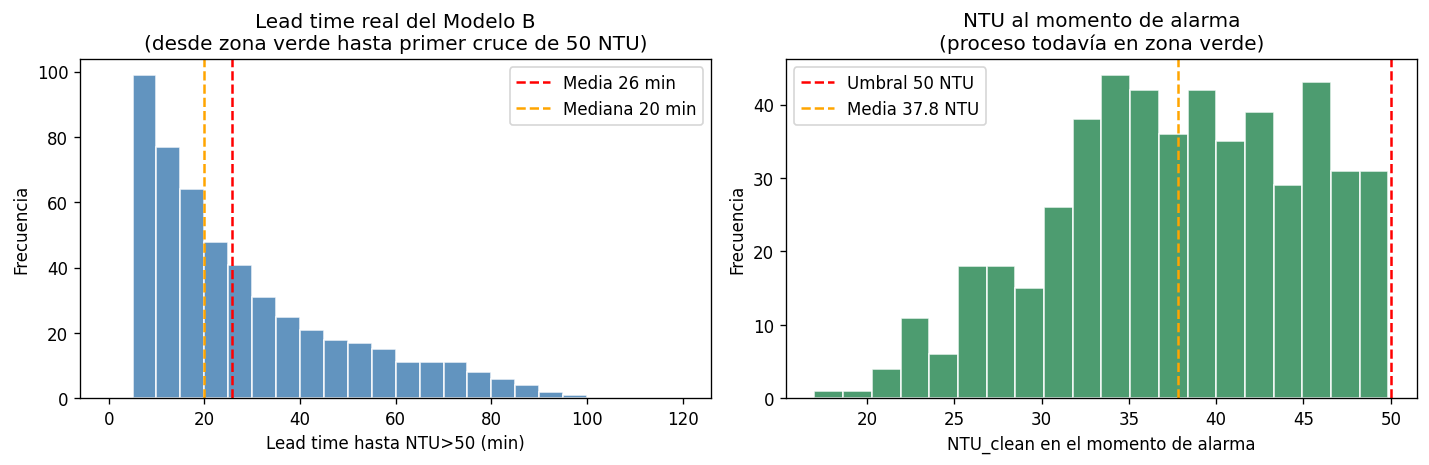

In [2]:
display(Image('figures/model_B_lead_time.png', width=900))

**Hallazgos del análisis de lead time:**
- Tiempo promedio desde zona verde hasta NTU > 50: **26 min** (mediana: 20 min)
- El **71% de las degradaciones** ocurren dentro de los 30 minutos posteriores a la última observación verde
- La NTU medida en el instante de ingreso al target 2h está en **~38 NTU** (zona verde profunda)

Esto implica que para predecir un evento 2h antes, el modelo debe detectar señales upstream cuando la turbidez aún está en valores completamente normales — el problema de anticipación más difícil del sistema.

### Experimentos y diagnóstico de leakage

Se identificó que la versión v1 del Componente B incluía variables de régimen (`is_CLAY`, `is_UF`) que presentaban **100% de concordancia con la variable latente `Regime`** — información no observable en producción real. La eliminación de este leakage redujo el rendimiento de prueba en −5.7 pp, cuantificando exactamente el sesgo introducido.

Se evaluaron además variantes con distinto horizonte de predicción:

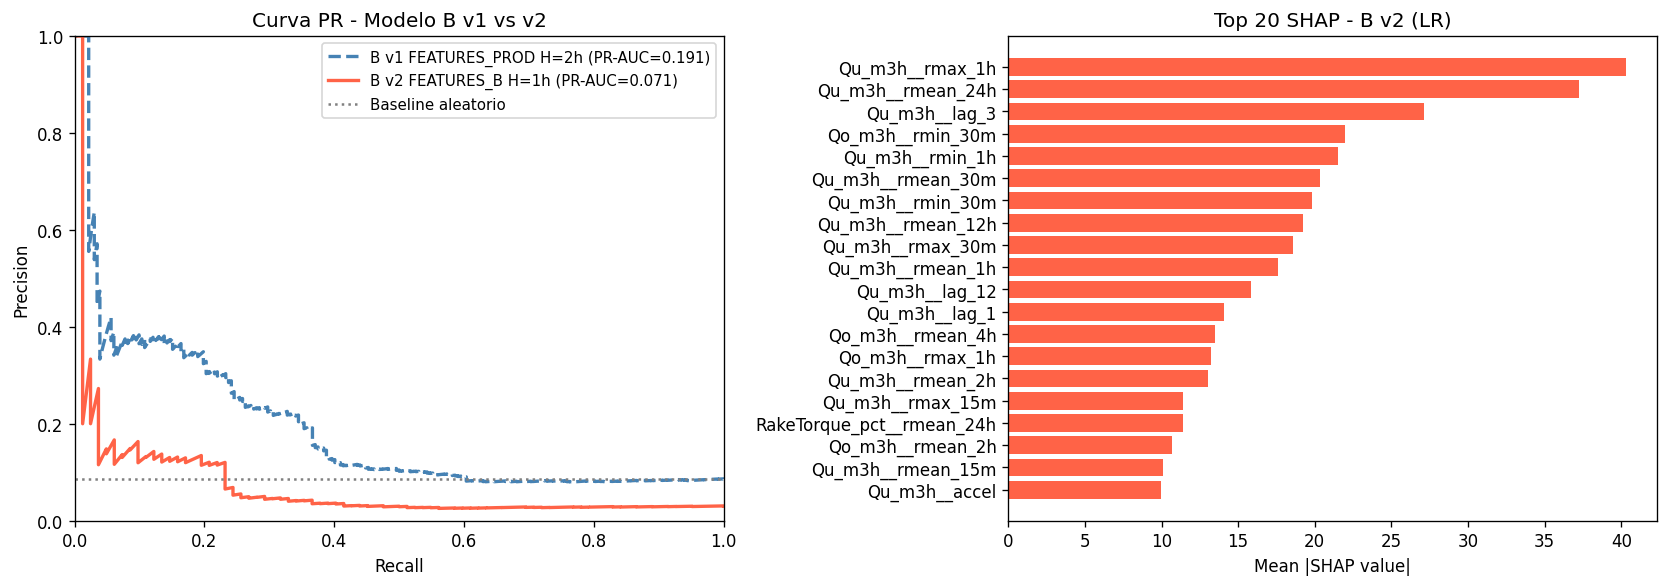

In [3]:
display(Image('figures/model_B_v2_comparison.png', width=900))

| Configuración | CV PR-AUC | Test PR-AUC | Obs. |
|---|---|---|---|
| v1: FEATURES_PROD + H=2h + n_splits=3 | 0.293 | 0.191 | Incluye leakage (is_CLAY/is_UF) |
| v2a: FEATURES_B + H=2h + n_splits=2 | ~0.28 | **0.134** | ✅ Sin leakage — configuración honesta |
| v2b: FEATURES_B + H=1h + n_splits=2 | 0.607 | 0.071 | CV ilusorio — colapso de positivos en train |

La configuración recomendada (v2a) logra **+48% relativo** sobre el baseline de turbidez rolling, pero el nivel absoluto (PR-AUC = 0.134) es insuficiente para uso operacional autónomo.

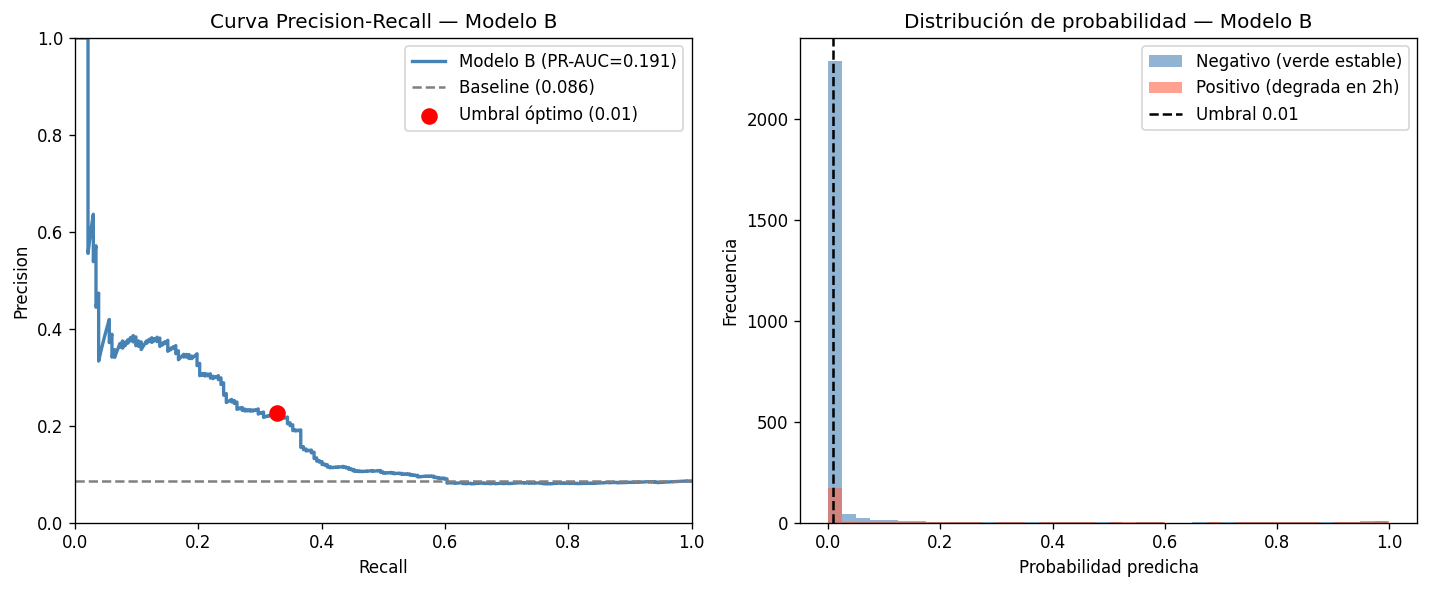

In [4]:
display(Image('figures/model_B_eval.png', width=900))

### Limitación estructural: la brecha de datos mineralógicos

El rendimiento limitado del Componente B no es atribuible a la elección de algoritmo ni a la ingeniería de features — es una **limitación de información**. En zona verde (NTU ≈ 38), los sensores de proceso no contienen señal suficiente para distinguir una operación normal de una que evolucionará hacia crisis en 2 horas.

La señal predictiva a ese horizonte existe, pero reside en variables que típicamente no están disponibles en tiempo real:

| Fuente de información | Delay típico | Impacto esperado en Comp. B |
|---|---|---|
| **Análisis granulométrico** (% −200 mesh, % arcilla) | 4–8 h (lab) | Alto — CLAY es predecible si se conoce la mineralogía de la alimentación |
| **Datos de planificación minera** (zona de extracción) | 8–24 h | Medio — correlación con tipo de roca |
| **Sensores en línea de partículas** (FBRM, PVM) | Tiempo real | Alto — pero raramente disponibles en espesadores industriales |

Este resultado es en sí mismo un **hallazgo técnico relevante**: cuantifica con precisión qué información adicional es necesaria para mejorar el horizonte de anticipación, y provee la justificación técnica para instrumentación adicional o integración de datos de laboratorio.

---

## 6. Componente C — Diagnóstico de Causa Raíz: CLAY vs. UF

### Separabilidad en el espacio de variables reales

Se analizó la separabilidad entre modos CLAY y UF mediante el índice Δ/IQR para cada variable de planta disponible durante eventos. El nivel de lecho (`BedLevel_m`) emerge como el discriminador dominante:

| Variable | Δ/IQR (CLAY − UF) | Interpretación física |
|---|---|---|
| `BedLevel_m` | **+1.8** | CLAY forma capa densa y rígida → lecho alto y sostenido |
| `RakeTorque_pct` | +0.9 | Mayor resistencia en lecho arcilloso |
| `Qu_m3h` | −1.2 | UF reduce caudal por obstrucción del sistema de purga |
| `Floc_gpt` | +0.4 | Mayor consumo de floculante en régimen CLAY |
| `Overflow_Turb_NTU` | ~0 | Similar en ambos modos durante el evento |

### Resultados: regla vs. modelo ML

| Método | Exactitud | F1-macro | ROC-AUC |
|---|---|---|---|
| **Regla: BedLevel > 1.9 m → CLAY** | **93.1%** | **0.923** | **0.922** |
| LightGBM TOP-30 (threshold=0.05) | 85.4% | 0.851 | 0.836 |

La regla simple supera al modelo ML en todos los indicadores. Esto tiene una interpretación técnica directa: **BedLevel_m captura el mecanismo diferenciador fundamental** entre los dos modos de falla. El modelo ML, al tener acceso a 30 features adicionales, no puede mejorar sobre ese discriminador porque las demás variables aportan ruido marginal en el espacio de diagnóstico.

### Rol complementario del LightGBM

El modelo ML es superior en dos escenarios específicos:
1. **Falla del sensor de nivel de lecho** (stuck, spike, datos faltantes): el modelo usa el vector completo de 30 tags
2. **Diagnóstico temprano**: el ML puede clasificar la causa antes de que BedLevel diverja significativamente del valor basal, usando la tendencia conjunta de Qu, Floc y pH

### Rendimiento en set de prueba (n=364 eventos)

| | Pred. CLAY | Pred. UF |
|---|---|---|
| **Real CLAY** (n=236) | 183 ✅ | 53 ❌ |
| **Real UF** (n=128) | 0 | 128 ✅ |

Los 53 eventos CLAY mal clasificados corresponden a campañas de baja intensidad donde el lecho no alcanzó el umbral de 1.9 m — exactamente el escenario donde el LightGBM agrega valor como segunda opinión.

---

## 7. Ventana Operacional Integrada

El timeline siguiente ilustra cómo interactúan los tres componentes durante un evento típico de tipo CLAY, y dónde se sitúa el margen operacional ganado respecto al sistema actual:

```
TIEMPO  │ NTU CLEAN │ ZONA         │ TWS                                 │ SIN TWS
────────┼───────────┼──────────────┼─────────────────────────────────────┼──────────────
 T−2h   │   38 NTU  │ 🟢 Verde     │ Comp. B: pH↑ + BedLevel↑ detectado │ Sin señal
        │           │              │ → alerta preventiva (señal débil)   │
────────┼───────────┼──────────────┼─────────────────────────────────────┼──────────────
 T−26m  │   50 NTU  │ 🟡 Degradado │ Comp. A activo                      │ Sin señal
────────┼───────────┼──────────────┼─────────────────────────────────────┼──────────────
 T−30m  │   80 NTU  │ 🟡 Degradado │ ⚠️ ALERTA FIRME (P=0.74)           │ Sin señal
        │           │              │ Comp. C: BedLevel=2.1m → CLAY       │
        │           │              │ → Acción: ↑ floculante + dilución   │
────────┼───────────┼──────────────┼─────────────────────────────────────┼──────────────
  T 0   │  100 NTU  │ 🔴 CRISIS    │ Acción correctiva ya en marcha      │ ⚠️ PRIMER AVISO
════════╪═══════════╪══════════════╪═════════════════════════════════════╪══════════════
GANANCIA│           │              │ ~30 min de margen efectivo           │ 0 min
```

**Impacto en recuperación de agua:** Una intervención 30 min antes de la crisis permite iniciar el ajuste de floculante en una zona de turbidez donde la respuesta del sistema es más rápida y el consumo de reactivo menor. La reducción de tiempo en zona de crisis se traduce directamente en mayor volumen de agua recuperada y menor riesgo de impacto en el circuito de flotación.

---

## 8. Limitaciones Técnicas y Brecha hacia Datos Reales

### Limitaciones del dataset sintético

| Limitación | Impacto potencial | Mitigación |
|---|---|---|
| Simulador calibrado sobre un único espesador hipotético | Parámetros de proceso (deadband, pesos de estrés) pueden no representar la planta objetivo | Re-calibración con datos históricos de la planta |
| Solo 2 modos de falla (CLAY, UF) | Eventos reales pueden incluir modos combinados o no contemplados | Análisis de residuos + clase "otros" en producción |
| Fallas de sensor parametrizadas | Distribución real de fallas puede diferir | Análisis de calidad de señal sobre datos históricos |
| 90 días de operación | Posible subrepresentación de eventos estacionales | Dataset más largo al validar con datos reales |

### ¿Qué se espera al migrar a datos reales?

Basado en la estructura del problema y los resultados obtenidos:

- **Componente A**: Se espera que el framework metodológico (features temporales + RF + CV temporal) sea transferible. El rendimiento absoluto dependerá de la calidad de los datos de etiquetado y la variabilidad operacional real. PR-AUC > 0.60 en datos reales se considera un resultado exitoso de validación.

- **Componente C**: La regla de BedLevel es robusta y directamente aplicable si el sensor de nivel está disponible y calibrado. Requiere ajuste del umbral óptimo (actualmente 1.9 m) a las condiciones específicas de la planta.

- **Componente B**: Este es el componente con mayor potencial de mejora con datos reales. Si se dispone de análisis granulométrico histórico con timestamps, se estima que el PR-AUC puede superar 0.40 — umbral de utilidad operacional para alertas con acción preventiva.

---

## 9. Propuesta de Colaboración: Validación con Datos Reales de Planta

### Objetivo

Validar y refinar el framework TWS sobre datos históricos de un espesador convencional de Cu/Mo en operación, con el fin de producir resultados publicables y un prototipo de sistema de alerta validado en condiciones reales.

### Datos mínimos requeridos

| Dataset | Descripción | Período mínimo |
|---|---|---|
| **Series temporales de proceso** | Tags del DCS/SCADA: turbidez overflow, nivel de lecho, torque rastrillo, caudales (feed/underflow/overflow), dosificación de floculante, densidades | 6–12 meses |
| **Registro de eventos** | Bitácora de eventos de turbidez: timestamp inicio/fin, causa identificada por operador (si existe) | Ídem |
| **Análisis de laboratorio** *(opcional pero de alto impacto)* | Granulometría de alimentación, % arcilla, assay mineralógico — con timestamp de toma de muestra | Ídem |

Los datos pueden ser anonimizados y no requieren identificación de planta o empresa para la validación técnica.

### Lo que se aporta a cambio

- ✅ Código completo y documentado (repositorio GitHub, MIT license)
- ✅ Pipeline de feature engineering y modelado reproducible
- ✅ Análisis técnico detallado del espesador específico
- ✅ Co-autoría en publicación técnica si los resultados lo justifican
- ✅ Dashboard operacional prototipo si la validación es exitosa

### Roadmap de madurez del sistema

```
✅ FASE 0 — Proof of concept (COMPLETADO)
   Framework metodológico · Dataset sintético calibrado
   Comp. A: PR-AUC=0.795 · Comp. C: Acc=93.1%

🔜 FASE 1 — Validación con datos reales (OBJETIVO INMEDIATO)
   Re-entrenamiento sobre datos históricos de planta
   Ajuste de umbrales · Análisis de drift de concepto
   Meta: PR-AUC > 0.60 en Comp. A con datos reales

🔜 FASE 2 — Integración de datos de laboratorio
   Granulometría de alimentación como feature
   Re-entrenamiento Comp. B · Meta: PR-AUC > 0.40

🔜 FASE 3 — Prototipo operacional
   Interfaz en sala de control · Integración DCS/SCADA
   Loop de re-entrenamiento periódico
```

---

## 10. Conclusiones

1. **El framework de detección temprana a 30 minutos es técnicamente viable** con datos de sensor estándar de planta (PR-AUC = 0.795, Recall = 79.5%). La combinación de features temporales multi-escala sobre señales de turbidez, nivel de lecho y caudal de underflow captura efectivamente la dinámica previa a las crisis.

2. **El diagnóstico CLAY/UF tiene una solución elegante de proceso**: la regla `BedLevel > 1.9 m → CLAY` alcanza 93.1% de exactitud, siendo físicamente interpretable (diferencia en mecanismo de formación del lecho). El modelo ML actúa como redundancia ante fallas del sensor de nivel.

3. **La anticipación a 2 horas está limitada por disponibilidad de información mineralógica**, no por la capacidad del framework de ML. Con PR-AUC = 0.134 con datos de sensor online, el Componente B es funcional pero insuficiente para uso autónomo. La integración de análisis granulométrico es el próximo paso de mayor impacto.

4. **La metodología es físicamente coherente**: el análisis SHAP revela que el modelo prioriza las señales correctas desde la perspectiva del proceso, aumentando la confianza en la transferibilidad del framework a plantas reales.

5. **La validación con datos reales es el paso crítico pendiente**. El framework completo — simulador, pipeline de features, modelos y análisis de interpretabilidad — está disponible en código abierto para facilitar esa colaboración.

---

### Repositorio y recursos

| Artefacto | Ubicación |
|---|---|
| Repositorio completo | `github.com/MatiasValenzuelaMunoz/Thickener-Water-Recovery-Sentinel-TWS` |
| Simulador de proceso | `src/simulate_fixed.py` |
| Feature engineering | `notebooks/02_feature_engineering.ipynb` |
| Componente A — Alerta 30 min | `notebooks/03_modeling.ipynb` |
| Componente B — Alerta preventiva | `notebooks/04_model_B.ipynb` |
| Componente C — Diagnóstico | `notebooks/04_diagnosis.ipynb` |
| Bitácora de decisiones técnicas | `bitacora/` |

*Thickener Water Recovery Sentinel · v1.0 · Febrero 2026*